In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from scipy import stats

import copy as copy

In [2]:
# read the data 
maindir = '/kaggle/input'
filepath_lst = []

for dirname, _, filenames in os.walk(maindir):
    for filename in filenames:
        filepath_lst.append(os.path.join(dirname, filename))

submission = pd.read_csv(filepath_lst[0])
train = pd.read_csv(filepath_lst[1])
test = pd.read_csv(filepath_lst[2])

# EDA

In [3]:
submission.shape, train.shape, test.shape

((67842, 2), (101763, 23), (67842, 22))

In [4]:
train.columns

Index(['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e',
       'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount',
       'defects'],
      dtype='object')

In [5]:
train.dtypes

id                     int64
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [7]:
features = train.drop(['defects','id'], axis = 1)
target = train['defects']

In [8]:
float_features = features.select_dtypes(include = 'float').columns.tolist()
int_features = features.select_dtypes(include = 'int').columns.tolist()
print(float_features)
print(int_features)

['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
['lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment']


In [9]:
features.describe().round().T

,count,mean,std,min,25%,50%,75%,max
loc,101763.0,37.0,55.0,1.0,13.0,22.0,42.0,3442.0
v(g),101763.0,5.0,8.0,1.0,2.0,3.0,6.0,404.0
ev(g),101763.0,3.0,5.0,1.0,1.0,1.0,3.0,165.0
iv(g),101763.0,3.0,6.0,1.0,1.0,2.0,4.0,402.0
n,101763.0,97.0,171.0,0.0,25.0,51.0,111.0,8441.0
v,101763.0,538.0,1271.0,0.0,98.0,233.0,560.0,80843.0
l,101763.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
d,101763.0,14.0,14.0,0.0,6.0,10.0,18.0,418.0
i,101763.0,28.0,23.0,0.0,16.0,23.0,34.0,570.0
e,101763.0,20854.0,190571.0,0.0,565.0,2256.0,10193.0,16846621.0


In [10]:
features.columns.tolist()[0]

'loc'

- outliers, feature scaling

In [11]:
# # check feature distribution
# fig, axes = plt.subplots(3,6, figsize = (15,6), constrained_layout = True)
# axes = axes.flatten()

# for i,j in zip(float_features,axes):
    
#     sns.kdeplot(train, x=i, ax = j, hue = "defects")
#     (mu, sigma) = norm.fit(train[i])
#     xmin, xmax = j.get_xlim()[0], j.get_xlim()[1]
#     x = np.linspace(xmin, xmax, 100)
#     p = norm.pdf(x, mu, sigma)
#     j.plot(x, p, 'k')

- what the distribution plots tell us:

1) number of false cases > number of true classes -> class imbalance -> check distribution after solving the class imbalance issue.

2) data distribution is close to normal distribution, but with higher peaks. 

3) feature values are at similar scales. feature scaling might not be necessary or helpful.

4) outliers. 

In [12]:
# # check for class imbalance
# train.groupby('defects')['id'].count()/train.shape[0]*100

In [13]:
# check feature correlations with target
corr = features.corrwith(target).to_frame()
corr['abs_corr'] = corr.abs()
corr.rename(columns = {0:'corr'}, inplace = True)
corr.sort_values(by = 'abs_corr', ascending = 0)

,corr,abs_corr
loc,0.342642,0.342642
branchCount,0.322827,0.322827
v(g),0.301187,0.301187
ev(g),0.259928,0.259928
n,0.258080,0.258080
lOBlank,0.257819,0.257819
l,-0.253237,0.253237
total_Opnd,0.252752,0.252752
lOCode,0.250604,0.250604
total_Op,0.250533,0.250533


In [14]:
feature_corr = features.corr().abs()
feature_corr_v2 = feature_corr.unstack().sort_values(ascending = False).to_frame().reset_index()
feature_corr_v2 = feature_corr_v2[feature_corr_v2['level_0']!=feature_corr_v2['level_1']]
feature_corr_v2

,level_0,level_1,0
21,branchCount,v(g),0.966702
22,v(g),branchCount,0.966702
23,total_Op,n,0.963373
24,n,total_Op,0.963373
25,total_Opnd,total_Op,0.960626
...,...,...,...
436,locCodeAndComment,e,0.124604
437,t,l,0.097000
438,l,t,0.097000
439,l,e,0.091764


In [15]:
# feature_corr_mask = np.triu(feature_corr,k=0)

# plt.figure(figsize=(16,8))
# sns.heatmap(feature_corr,
#            mask = feature_corr_mask,
#            annot = True,
#            fmt = '.1f',
#            cmap = 'coolwarm',
#            linewidth = 0.1,
#            cbar = True
#            )

# plt.suptitle("Features Correlation Heatmap", weight = 'bold', size = 20)
# plt.tight_layout()

- there are several pairs of features that are highly correlated with each other; need to either remove, or use dimension deduction techniques to condense information, or choose tree-method which is immune to feature correlation.

- variables that are highly-correlated with other features: loc, n, v, d, b, IOCode, uniq_Opnd, total_Op, total_Opnd

1) loc & v(g); v(g) & ev(g); n & v
2) loc & iv(g); v(g) & iv(g); n & d
3) loc & n; v(g) & branchCount; n & i
4) loc & v; n & b;
5) loc & b; n & IOCode
6) loc & IOCode; n & IOBlank
7) loc & IOBlank; n & Uniq_Opnd
8) loc & total_Op; n & total_Op;
9) loc & total_Opnd; n & total_Opnd
10) loc & branchCount..

In [16]:
high_corr_features = feature_corr_v2[feature_corr_v2[0]>0.8]
high_corr_features.head(3)

,level_0,level_1,0
21,branchCount,v(g),0.966702
22,v(g),branchCount,0.966702
23,total_Op,n,0.963373


In [17]:
high_corr_features.reset_index().loc[0,'level_0']

'branchCount'

In [18]:
# # examine if outliers are the reasons why features are highly-correlated with each other

# fig, axes = plt.subplots(4,6, figsize = (16,6))
# axes = axes.flatten()

# i = 0
# for row in range(0,48,2):
#     feature_a = high_corr_features.reset_index(drop = True).loc[row, ['level_0','level_1']][0]
#     feature_b = high_corr_features.reset_index(drop = True).loc[row, ['level_0','level_1']][1]
    
#     sns.regplot(features, x = feature_a, y = feature_b, ci = None, order = 1, ax = axes[i], scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    
#     i+=1

# plt.tight_layout()
    

In [19]:
# # regplots after deweighting outliers
# fig, axes = plt.subplots(4, 6, figsize = (16, 8))
# axes = axes.flatten()

# i = 0 
# for row in range(0,48,2):
#     feature_a = high_corr_features.reset_index(drop=True).loc[row, 'level_0']
#     feature_b = high_corr_features.reset_index(drop=True).loc[row, 'level_1']
    
#     sns.regplot(features, x = feature_a, y = feature_b, order = 1, robust = True, scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    
#     i+=1

# plt.tight_layout()

- regplot with robust = True takes reallllllly long time to run...better be worth the time. 
- take too much time to run, give up

# Build Baseline Model

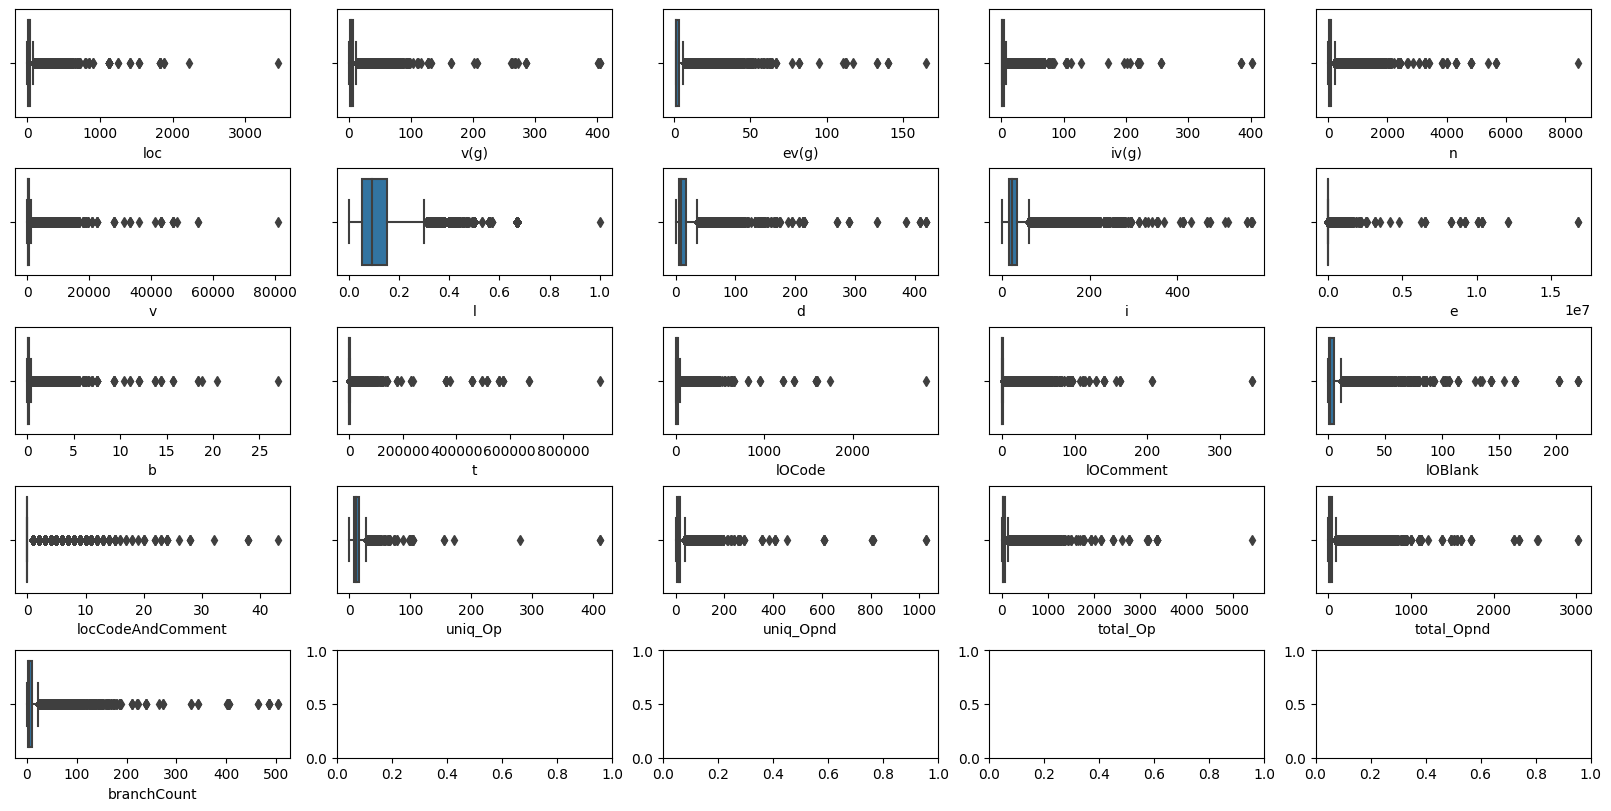

In [20]:
# before scaling & normalization 
fig, axes = plt.subplots(5,5, figsize=(16,8), constrained_layout = True)
axes = axes.flatten()

for i in range(21):
    sns.boxplot(data = train.drop(['id'],axis = 1), x = features.columns.tolist()[i], ax = axes[i])

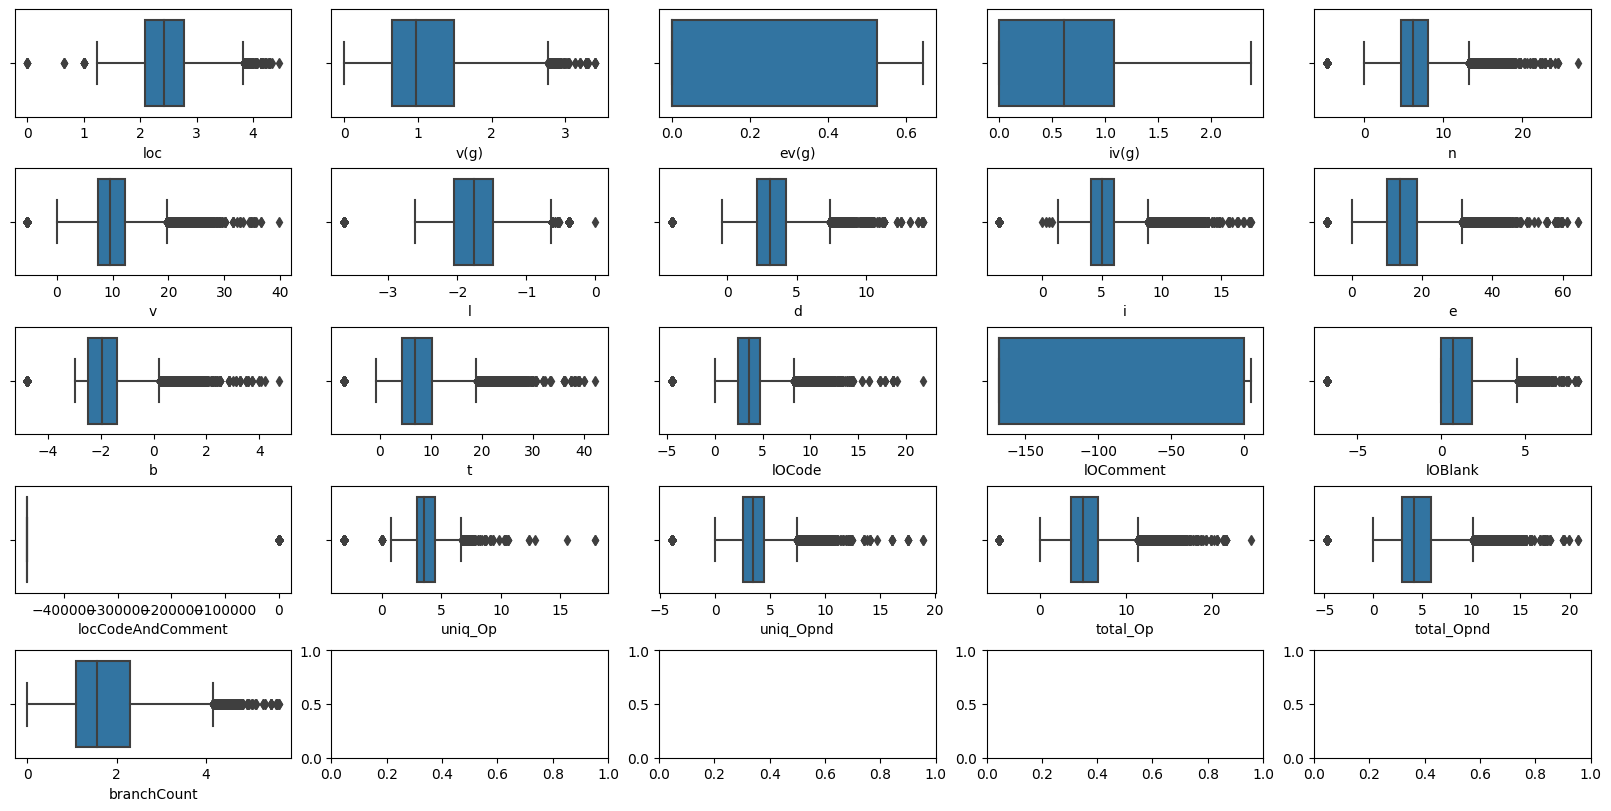

In [21]:
# after scaling & normalization 
fig, axes = plt.subplots(5,5, figsize=(16,8), constrained_layout = True)
axes = axes.flatten()

train_copy = copy.deepcopy(train)
FEATURES = train_copy.drop(['id','defects'], axis = 1)


for i in range(FEATURES.shape[1]):
    FEATURES.iloc[:,i] = stats.boxcox(FEATURES.iloc[:,i]+1e-13)[0]

# standardization
MMS = MinMaxScaler()
MMS.fit(FEATURES)
FEATURES_scaled = MMS.transform(FEATURES)

for i in range(21):
    sns.boxplot(data = FEATURES, x = FEATURES.columns.tolist()[i], ax = axes[i])

In [22]:
# calculate vif for each feature to evaluate multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["feature"] = features.columns
vif["vif"] = [variance_inflation_factor(features.values,i) for i in range(len(features.columns.tolist()))]
vif = vif.sort_values(by = 'vif', ascending = 0)
vif

,feature,vif
20,branchCount,30.621024
1,v(g),29.859972
19,total_Opnd,28.862048
18,total_Op,28.509749
4,n,24.689084
5,v,15.373596
12,lOCode,13.876799
10,b,13.467452
7,d,11.519900
16,uniq_Op,11.263437


In [23]:
vif['feature'][0:2].tolist()

['branchCount', 'v(g)']

In [24]:
# parameters = {
# 'solver':['liblinear','sag','saga'],    
# 'penalty':['l1','l2'],    
#  'max_iter':[300,400,500], 
# 'C': [1.0, 2.0,3.0, 4.0, 5.0]
# }

# best parameters: C:4.0, solver:saga, penalty:l1, max_iter:400

X = features.drop(vif['feature'][0:2].tolist(), axis = 1)
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
# boxcox nomarlization

for i in range(X_train.shape[1]):
    X_train.iloc[:,i] = stats.boxcox(X_train.iloc[:,i]+1e-13)[0]

for i in range(X_test.shape[1]):
    X_test.iloc[:,i] = stats.boxcox(X_test.iloc[:,i]+1e-13)[0]

# standardization
mms = MinMaxScaler()
mms.fit(X_train)
X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)

In [26]:
# train the mod__class_getitem__el
lg = LogisticRegression(solver='saga', penalty='l1', C = 4.0, max_iter=400)
lg.fit(X_train_scaled, y_train)
# clf = GridSearchCV(lg, parameters, scoring = 'roc_auc',verbose = 0)
# clf.fit(X_train_scaled, y_train)
y_pred = lg.predict_proba(X_test_scaled)[:,1]
lg_roc_auc_score = roc_auc_score(y_test, y_pred)
print("roc_auc_score of the baseline logistic model is: {:.4f}". format(lg_roc_auc_score))

roc_auc_score of the baseline logistic model is: 0.7802


In [27]:
pd.DataFrame({'feature_name':X_train.columns,'feature_coef':lg.coef_.round(2).reshape(-1)}).sort_values(by='feature_coef', ascending = 1)

,feature_name,feature_coef
6,d,-4.93
11,lOCode,-4.75
18,total_Opnd,-3.80
7,i,-3.34
13,lOBlank,-0.44
12,lOComment,-0.01
1,ev(g),0.10
17,total_Op,0.14
14,locCodeAndComment,0.20
2,iv(g),0.37


- v, e, t, n is almost shrinked to zero. make sense bc they either rarely correlates with target, or they are highly correlated with other variables.
- baseline model 0.7764 with l1 penalty.
- e1: perform feature scaling by minmaxscaler, 0.7768.
- e2: perform feature normalizing with boxcox on all features, 0.7646
- e3: gridsearch to find best parameters; elastcnet requires C and l1_ratio, making it hard to add it to the process.takes so long to train. didnt find the best parameters that beat 0.7768.
- e4: e1 + e2 + e3, 0.7802
- e5: remove features with top 2 vif score: 'branchCount', 'v(g)', 0.7802
- e6: class imbalance

# Submission

In [28]:
test = test.drop(['id']+vif['feature'][0:2].tolist(), axis = 1)

# normalization
for i in range(test.shape[1]):
    test.iloc[:,i] = stats.boxcox(test.iloc[:,i]+1e-13)[0]

# standardization
mms_test = MinMaxScaler()
mms_test.fit(test)
test_scaled = mms_test.transform(test)

In [29]:
test_pred = lg.predict_proba(test_scaled)[:,1]
test_pred

array([0.2107281 , 0.17342438, 0.64335652, ..., 0.16738562, 0.09777877,
       0.72767486])

In [30]:
submission['defects'] = test_pred
submission

,id,defects
0,101763,0.210728
1,101764,0.173424
2,101765,0.643357
3,101766,0.406191
4,101767,0.137586
...,...,...
67837,169600,0.238683
67838,169601,0.132879
67839,169602,0.167386
67840,169603,0.097779


In [31]:
submission.to_csv("submission.csv", index=False)